## Построение регрессора для предсказания непрерывной величины (*Практическая* часть)

**Задание базового уровня**

Вашим заданием в данной лабораторной будет построение регрессионной модели для предсказания цены квартиры для датасета, содержащего информацию о продаже недвижимости в Нью-Йорке.

https://www.kaggle.com/new-york-city/nyc-property-sales

**Задание повышенного уровня**

Выполнить задание базового уровня. Методика оценки - **mean_absolute_error**. Ошибка для полученного решения должна быть ниже отметки **125000**.

Размер датасета после всех производимых манипуляций должен быть больше **50000** записей.


In [530]:
import pandas as pd
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [531]:
df = pd.read_csv('/kaggle/input/nyc-property-sales/nyc-rolling-sales.csv')
df.head(5)

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [532]:
df=df.drop(columns=['Unnamed: 0'])

In [533]:
df.drop('EASE-MENT', axis=1, inplace=True)

In [534]:
counts_ = df.applymap(lambda x: str(x).count("-"))
counts_space = df.applymap(lambda x: str(x).count(" "))
print(f"there is {counts_.sum().sum()} '-' and {counts_space.sum().sum()} spaces")

there is 321133 '-' and 2406973 spaces


In [535]:
map_dict={'-':np.nan,' ':np.nan}
df.replace(map_dict,inplace = True)

In [536]:
sum(df.duplicated())

765

In [537]:
df.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                738
BLOCK                                 0
LOT                                   0
BUILDING CLASS AT PRESENT           738
ADDRESS                               0
APARTMENT NUMBER                  65496
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                      0
GROSS SQUARE FEET                     0
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
dtype: int64

In [538]:
numeric_columns = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE']
for col in df.columns:
    if col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [539]:
for col in ['LAND SQUARE FEET', 'GROSS SQUARE FEET']:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

df = df.dropna(subset=['SALE PRICE'])

df_info = {
    "Missing Values After Imputation": df[numeric_columns].isnull().sum(),
    "Remaining Rows": len(df)
}

df_info

{'Missing Values After Imputation': LAND SQUARE FEET     0
 GROSS SQUARE FEET    0
 SALE PRICE           0
 dtype: int64,
 'Remaining Rows': 69987}

In [540]:
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

In [541]:
df['year'] = df['SALE DATE'].dt.year
df['month'] = df['SALE DATE'].dt.month

In [542]:
df = df.drop(columns=['SALE DATE'])

In [543]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 84547
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         69987 non-null  int64  
 1   NEIGHBORHOOD                    69987 non-null  object 
 2   BUILDING CLASS CATEGORY         69987 non-null  object 
 3   TAX CLASS AT PRESENT            69314 non-null  object 
 4   BLOCK                           69987 non-null  int64  
 5   LOT                             69987 non-null  int64  
 6   BUILDING CLASS AT PRESENT       69314 non-null  object 
 7   ADDRESS                         69987 non-null  object 
 8   APARTMENT NUMBER                15496 non-null  object 
 9   ZIP CODE                        69987 non-null  int64  
 10  RESIDENTIAL UNITS               69987 non-null  int64  
 11  COMMERCIAL UNITS                69987 non-null  int64  
 12  TOTAL UNITS                     69987

In [544]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['NEIGHBORHOOD']= le.fit_transform(df['NEIGHBORHOOD'])
df['BUILDING CLASS CATEGORY']= le.fit_transform(df['BUILDING CLASS CATEGORY']) 
df['TAX CLASS AT PRESENT']= le.fit_transform(df['TAX CLASS AT PRESENT']) 
df['BUILDING CLASS AT PRESENT']= le.fit_transform(df['BUILDING CLASS AT PRESENT'])
df['BUILDING CLASS AT TIME OF SALE']= le.fit_transform(df['BUILDING CLASS AT TIME OF SALE'])
  
df = df.drop(columns=['ADDRESS', 'APARTMENT NUMBER'])

In [545]:
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,year,month
0,1,1,6,5,392,6,15,10009,5,0,5,1633.0,6440.0,1900,2,15,6625000.0,2017,7
3,1,1,6,6,402,21,17,10009,10,0,10,2272.0,6794.0,1913,2,17,3936272.0,2016,9
4,1,1,6,5,404,55,15,10009,6,0,6,2369.0,4615.0,1900,2,15,8000000.0,2016,11
6,1,1,6,6,406,32,17,10009,8,0,8,1750.0,4226.0,1920,2,17,3192840.0,2016,9
9,1,1,7,4,387,153,33,10009,24,0,24,4489.0,18523.0,1920,2,33,16232000.0,2016,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,5,251,1,0,7349,34,12,10309,2,0,2,2400.0,2575.0,1998,1,12,450000.0,2016,11
84544,5,251,1,0,7349,78,12,10309,2,0,2,2498.0,2377.0,1998,1,12,550000.0,2017,4
84545,5,251,1,0,7351,60,10,10309,2,0,2,4000.0,1496.0,1925,1,10,460000.0,2017,7
84546,5,251,20,9,7100,28,81,10309,0,7,7,208033.0,64117.0,2001,4,82,11693337.0,2016,12


In [546]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 84547
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         69987 non-null  int64  
 1   NEIGHBORHOOD                    69987 non-null  int64  
 2   BUILDING CLASS CATEGORY         69987 non-null  int64  
 3   TAX CLASS AT PRESENT            69987 non-null  int64  
 4   BLOCK                           69987 non-null  int64  
 5   LOT                             69987 non-null  int64  
 6   BUILDING CLASS AT PRESENT       69987 non-null  int64  
 7   ZIP CODE                        69987 non-null  int64  
 8   RESIDENTIAL UNITS               69987 non-null  int64  
 9   COMMERCIAL UNITS                69987 non-null  int64  
 10  TOTAL UNITS                     69987 non-null  int64  
 11  LAND SQUARE FEET                69987 non-null  float64
 12  GROSS SQUARE FEET               69987

array([[<Axes: title={'center': 'SALE PRICE'}>]], dtype=object)

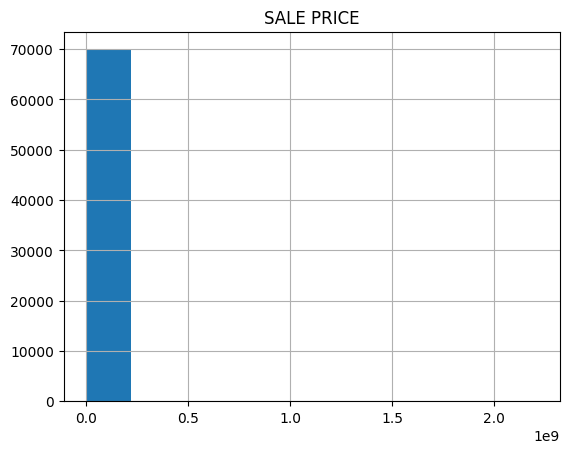

In [547]:
df.hist(["SALE PRICE"])

In [548]:
# for i in range(1_000_000, 4_000_000, 100_000):
#     for j in range(100_000, 200_000, 10_000):
#         df_copy = df
#         df_copy = df_copy[(df_copy['SALE PRICE'] < i) & (df_copy['SALE PRICE'] > j)]
#         df.reset_index(inplace=True)
#         del df['index']
#         df_copy.shape
        
#         if df_copy.shape[0] >= 50_000 and df_copy.shape[0] <= 51_000:
#             y = df_copy['SALE PRICE']
#             X = df_copy.drop(columns=('SALE PRICE'))

#             X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#             rf_model = RandomForestRegressor()
#             rf_model.fit(X_train, y_train)
#             rf_predict = rf_model.predict(X_test)
#             mae = mean_absolute_error(y_test, rf_predict)
            
#             if mae <= 170_000:
#                 print(mae)
#                 print()
#                 print(i, j, rf_model.get_params(deep=True))
                

**BEST**
167252.2181634422

2000000 100000 {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

In [549]:
df_copy = df
df_copy = df_copy[(df_copy['SALE PRICE'] < 2000000) & (df_copy['SALE PRICE'] > 100000)]
df.reset_index(inplace=True)
del df['index']
df_copy.shape

(50194, 19)

array([[<Axes: title={'center': 'SALE PRICE'}>]], dtype=object)

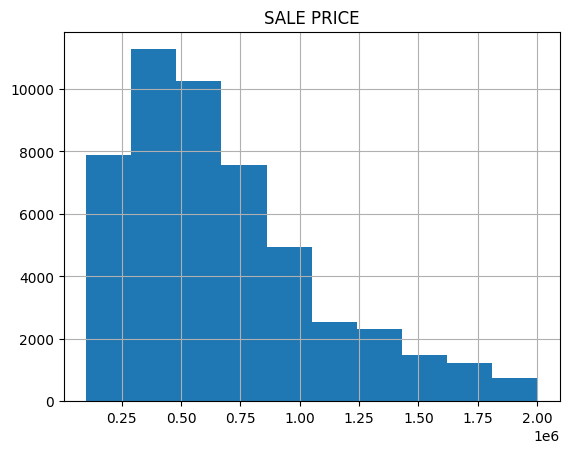

In [550]:
df_copy.hist(["SALE PRICE"])

In [551]:
y = df_copy['SALE PRICE']
X = df_copy.drop(columns=('SALE PRICE'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predict = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, rf_predict)

In [552]:
mae

166246.47809443923

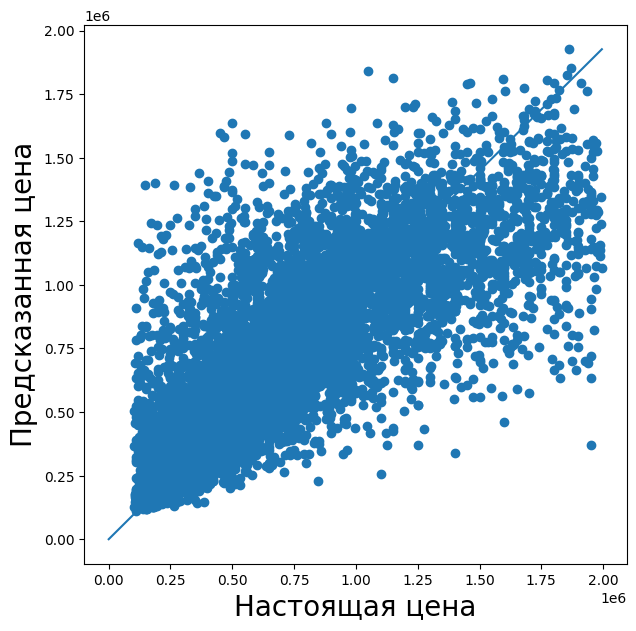

In [553]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, rf_predict) 
plt.plot([0, max(y_test)], [0, max(rf_predict)]) 
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);

**MAE = 166246.47809443923**